In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install keras



You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:

import numpy as np
import json
import tensorflow as tf
import os


def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()


class ConvVAE(object):
  def __init__(self, z_size=32, batch_size=1, learning_rate=0.0001, kl_tolerance=0.5, is_training=False,
               reuse=False, gpu_mode=False):
    self.z_size = z_size
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.is_training = is_training
    self.kl_tolerance = kl_tolerance
    self.reuse = reuse

    with tf.variable_scope('conv_vae', reuse=self.reuse):
      if not gpu_mode:
        with tf.device('/cpu:0'):
          tf.logging.info('Model using cpu.')
          self._build_graph()
      else:
        tf.logging.info('Model using gpu.')
        self._build_graph()
    self._init_session()

  def _build_graph(self):
    self.g = tf.Graph()
    with self.g.as_default():

      self.x = tf.placeholder(tf.float32, shape=[None, 64, 64, 3])

      # Encoder
      h = tf.layers.conv2d(self.x, 32, 4, strides=2, activation=tf.nn.relu, name="enc_conv1")
      h = tf.layers.conv2d(h, 64, 4, strides=2, activation=tf.nn.relu, name="enc_conv2")
      h = tf.layers.conv2d(h, 128, 4, strides=2, activation=tf.nn.relu, name="enc_conv3")
      h = tf.layers.conv2d(h, 256, 4, strides=2, activation=tf.nn.relu, name="enc_conv4")
      h = tf.reshape(h, [-1, 2*2*256])

      # VAE
      self.mu = tf.layers.dense(h, self.z_size, name="enc_fc_mu")
      self.logvar = tf.layers.dense(h, self.z_size, name="enc_fc_log_var")
      self.sigma = tf.exp(self.logvar / 2.0)
      self.epsilon = tf.random_normal([self.batch_size, self.z_size])
      self.z = self.mu + self.sigma * self.epsilon

      # Decoder
      h = tf.layers.dense(self.z, 4*256, name="dec_fc")
      h = tf.reshape(h, [-1, 1, 1, 4*256])
      h = tf.layers.conv2d_transpose(h, 128, 5, strides=2, activation=tf.nn.relu, name="dec_deconv1")
      h = tf.layers.conv2d_transpose(h, 64, 5, strides=2, activation=tf.nn.relu, name="dec_deconv2")
      h = tf.layers.conv2d_transpose(h, 32, 6, strides=2, activation=tf.nn.relu, name="dec_deconv3")
      self.y = tf.layers.conv2d_transpose(h, 3, 6, strides=2, activation=tf.nn.sigmoid, name="dec_deconv4")
      
      # train ops
      if self.is_training:
        self.global_step = tf.Variable(0, name='global_step', trainable=False)

        eps = 1e-6 # avoid taking log of zero
        
        # reconstruction loss
        self.r_loss = tf.reduce_sum(
          tf.square(self.x - self.y),
          reduction_indices = [1,2,3]
        )
        self.r_loss = tf.reduce_mean(self.r_loss)

        # augmented kl loss per dim
        self.kl_loss = - 0.5 * tf.reduce_sum(
          (1 + self.logvar - tf.square(self.mu) - tf.exp(self.logvar)),
          reduction_indices = 1
        )
        self.kl_loss = tf.maximum(self.kl_loss, self.kl_tolerance * self.z_size)
        self.kl_loss = tf.reduce_mean(self.kl_loss)
        
        self.loss = self.r_loss + self.kl_loss
        
        # training
        self.lr = tf.Variable(self.learning_rate, trainable=False)
        self.optimizer = tf.train.AdamOptimizer(self.lr)
        grads = self.optimizer.compute_gradients(self.loss) # can potentially clip gradients here.

        self.train_op = self.optimizer.apply_gradients(
          grads, global_step=self.global_step, name='train_step')

      # initialize vars
      self.init = tf.global_variables_initializer()
      
      t_vars = tf.trainable_variables()
      self.assign_ops = {}
      for var in t_vars:
        #if var.name.startswith('conv_vae'):
        pshape = var.get_shape()
        pl = tf.placeholder(tf.float32, pshape, var.name[:-2]+'_placeholder')
        assign_op = var.assign(pl)
        self.assign_ops[var] = (assign_op, pl)


  def _init_session(self):
    """Launch TensorFlow session and initialize variables"""
    self.sess = tf.Session(graph=self.g)
    self.sess.run(self.init)
      
  def close_sess(self):
    """ Close TensorFlow session """
    self.sess.close()
      
  def encode(self, x):
    return self.sess.run(self.z, feed_dict={self.x: x})
  
  def encode_mu_logvar(self, x):
    (mu, logvar) = self.sess.run([self.mu, self.logvar], feed_dict={self.x: x})
    return mu, logvar
  
  def decode(self, z):
    return self.sess.run(self.y, feed_dict={self.z: z})
  
  def decode_mu_logvar(self, mu, logvar):
    return self.sess.run(self.y, feed_dict={self.mu: mu, self.logvar:logvar})
  
  def get_model_params(self):
    # get trainable params.
    model_names = []
    model_params = []
    model_shapes = []
    with self.g.as_default():
      t_vars = tf.trainable_variables()
      for var in t_vars:
        #if var.name.startswith('conv_vae'):
        param_name = var.name
        p = self.sess.run(var)
        model_names.append(param_name)
        params = np.round(p*10000).astype(np.int).tolist()
        model_params.append(params)
        model_shapes.append(p.shape)
    return model_params, model_shapes, model_names
  
  def get_random_model_params(self, stdev=0.5):
    # get random params.
    _, mshape, _ = self.get_model_params()
    rparam = []
    for s in mshape:
      #rparam.append(np.random.randn(*s)*stdev)
      rparam.append(np.random.standard_cauchy(s)*stdev) # spice things up
    return rparam
  
  def set_model_params(self, params):
    with self.g.as_default():
      t_vars = tf.trainable_variables()
      idx = 0
      for var in t_vars:
        #if var.name.startswith('conv_vae'):
        pshape = tuple(var.get_shape().as_list())
        p = np.array(params[idx])
        assert pshape == p.shape, "inconsistent shape"
        assign_op, pl = self.assign_ops[var]
        self.sess.run(assign_op, feed_dict={pl.name: p/10000.})
        idx += 1
              
  def load_json(self, jsonfile='vae.json'):
    with open(jsonfile, 'r') as f:
      params = json.load(f)
    self.set_model_params(params)
      
  def save_json(self, jsonfile='vae.json'):
    model_params, model_shapes, model_names = self.get_model_params()
    qparams = []
    for p in model_params:
      qparams.append(p)
    with open(jsonfile, 'wt') as outfile:
      json.dump(qparams, outfile, sort_keys=True, indent=0, separators=(',', ': '))
          
  def set_random_params(self, stdev=0.5):
    rparam = self.get_random_model_params(stdev)
    self.set_model_params(rparam)
      
  def save_model(self, model_save_path):
    sess = self.sess
    with self.g.as_default():
      saver = tf.train.Saver(tf.global_variables())
    checkpoint_path = os.path.join(model_save_path, 'vae')
    tf.logging.info('saving model %s.', checkpoint_path)
    saver.save(sess, checkpoint_path, 0) # just keep one
      
  def load_checkpoint(self, checkpoint_path):
    sess = self.sess
    with self.g.as_default():
      saver = tf.train.Saver(tf.global_variables())
    ckpt = tf.train.get_checkpoint_state(checkpoint_path)
    print('loading model', ckpt.model_checkpoint_path)
    tf.logging.info('Loading model %s.', ckpt.model_checkpoint_path)
    saver.restore(sess, ckpt.model_checkpoint_path)



In [3]:

# Hyperparameters for ConvVAE
z_size=32
batch_size=64
learning_rate=0.0001
kl_tolerance=0.5

vae = ConvVAE(z_size=z_size,
              batch_size=batch_size,
              learning_rate=learning_rate,
              kl_tolerance=kl_tolerance,
              is_training=True,
              reuse=False,
              gpu_mode=True)

reset_graph()
total_epochs = 0



INFO:tensorflow:Model using gpu.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Use tf.cast instead.


In [4]:
game_name = "Skiing"
total_epochs = 160
vae.load_json(f"tf_vae/vae_epochs_{game_name}_{total_epochs}.json")




In [5]:

game_name = "Skiing"
output = "v0"

import os
record_files = [filename for filename in os.listdir(f'./record/{game_name}')
                    if os.path.isfile(f"./record/{game_name}/{filename}") and filename.startswith(f"record_{game_name}")]

input = []
output = []

for file in record_files[20:50]:
    print("load file: ", file)
    data = np.load(f"./record/{game_name}/{file}", allow_pickle=True)
    downsampled = data["obs_downsampled"]
    actions = data["actions"]
    rewards = data["rewards"]
    
    downsampled = downsampled / 255.
    
    current_input = np.zeros((downsampled.shape[0]-1, 65)) #mu+logvar+action of t
    current_output = np.zeros((downsampled.shape[0]-1, 64)) #mu+logvar of t+1

    for row in range(0,downsampled.shape[0]):
        value = vae.encode_mu_logvar(downsampled[row,:,:,:].reshape((1,64,64,3)))
        value = np.concatenate(value, axis=1)
        if row < downsampled.shape[0]-1:
            current_input[row,:-1] = value
            current_input[row,-1] = actions[row+1]
        if row > 0:
            current_output[row-1] = np.concatenate(value)
            
    if len(input) == 0:
        input = current_input
        output = current_output
    else:
        input = np.concatenate((input, current_input))
        output = np.concatenate((output, current_output))
    
  

load file:  record_Skiing_v0_26.npz
load file:  record_Skiing_v0_27.npz
load file:  record_Skiing_v0_28.npz
load file:  record_Skiing_v0_29.npz
load file:  record_Skiing_v0_3.npz
load file:  record_Skiing_v0_30.npz
load file:  record_Skiing_v0_31.npz
load file:  record_Skiing_v0_32.npz
load file:  record_Skiing_v0_33.npz
load file:  record_Skiing_v0_34.npz
load file:  record_Skiing_v0_35.npz
load file:  record_Skiing_v0_36.npz
load file:  record_Skiing_v0_37.npz
load file:  record_Skiing_v0_38.npz
load file:  record_Skiing_v0_39.npz
load file:  record_Skiing_v0_4.npz
load file:  record_Skiing_v0_40.npz
load file:  record_Skiing_v0_41.npz
load file:  record_Skiing_v0_42.npz
load file:  record_Skiing_v0_43.npz
load file:  record_Skiing_v0_44.npz
load file:  record_Skiing_v0_45.npz
load file:  record_Skiing_v0_46.npz
load file:  record_Skiing_v0_47.npz
load file:  record_Skiing_v0_48.npz
load file:  record_Skiing_v0_49.npz
load file:  record_Skiing_v0_5.npz
load file:  record_Skiing_v0_50

In [6]:
input_train = input[:int(len(input)*0.8),:]
input_test = input[int(len(input)*0.8):,:]
output_train = output[:int(len(output)*0.8),:]
output_test = output[int(len(output)*0.8):,:]


In [24]:
from keras.layers import Dense
from keras.models import Sequential
from keras import backend as K

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=65))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='linear'))
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])


In [25]:
model.fit(input_train, output_train,
            epochs=50,
            batch_size=100,
            shuffle=True,
            validation_data=(input_test, output_test))



Train on 40113 samples, validate on 10029 samples
Epoch 1/50
40113/40113 [==============================] - 2s 49us/step - loss: 0.1377 - mean_squared_error: 0.1377 - val_loss: 0.0275 - val_mean_squared_error: 0.0275
Epoch 2/50
40113/40113 [==============================] - 1s 31us/step - loss: 0.0249 - mean_squared_error: 0.0249 - val_loss: 0.0235 - val_mean_squared_error: 0.0235
Epoch 3/50
40113/40113 [==============================] - 1s 31us/step - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0223 - val_mean_squared_error: 0.0223
Epoch 4/50
40113/40113 [==============================] - 1s 31us/step - loss: 0.0214 - mean_squared_error: 0.0214 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 5/50
40113/40113 [==============================] - 1s 30us/step - loss: 0.0207 - mean_squared_error: 0.0207 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 6/50
40113/40113 [==============================] - 1s 30us/step - loss: 0.0200 - mean_squared_error: 0.0200 

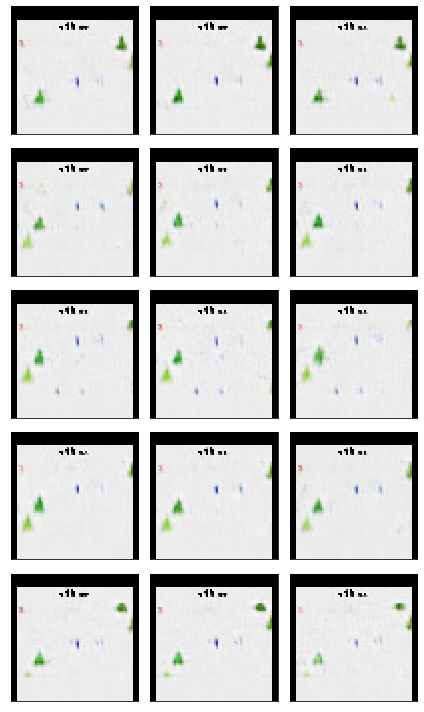

In [28]:
import random
idx = 0
obs = input_test
obs_out = output_test

n = 5
_, ax = plt.subplots(n,3, figsize=(6,10))

for i, ind in enumerate(random.sample(range(batch_size), n)):
    # display original
    img = vae.decode_mu_logvar(obs[ind,:32].reshape(1,32), obs[ind,32:-1].reshape(1,32))
    ax[i,0].imshow(img[0,:,:,:])
    ax[i,0].get_xaxis().set_visible(False)
    ax[i,0].get_yaxis().set_visible(False)
    
    
    # display original reconstruction
    img = vae.decode_mu_logvar(obs_out[ind,:32].reshape(1,32), obs_out[ind,32:].reshape(1,32))
    ax[i,1].imshow(img[0,:,:,:])
    ax[i,1].get_xaxis().set_visible(False)
    ax[i,1].get_yaxis().set_visible(False)
    
    # display predicted reconstruction
    pred = model.predict(obs[ind].reshape(1,65))
    img = vae.decode_mu_logvar(pred[0,:32].reshape(1,32), pred[0,32:].reshape(1,32))
    ax[i,2].imshow(img[0,:,:,:])
    ax[i,2].get_xaxis().set_visible(False)
    ax[i,2].get_yaxis().set_visible(False)
    
    
plt.tight_layout()
plt.show()


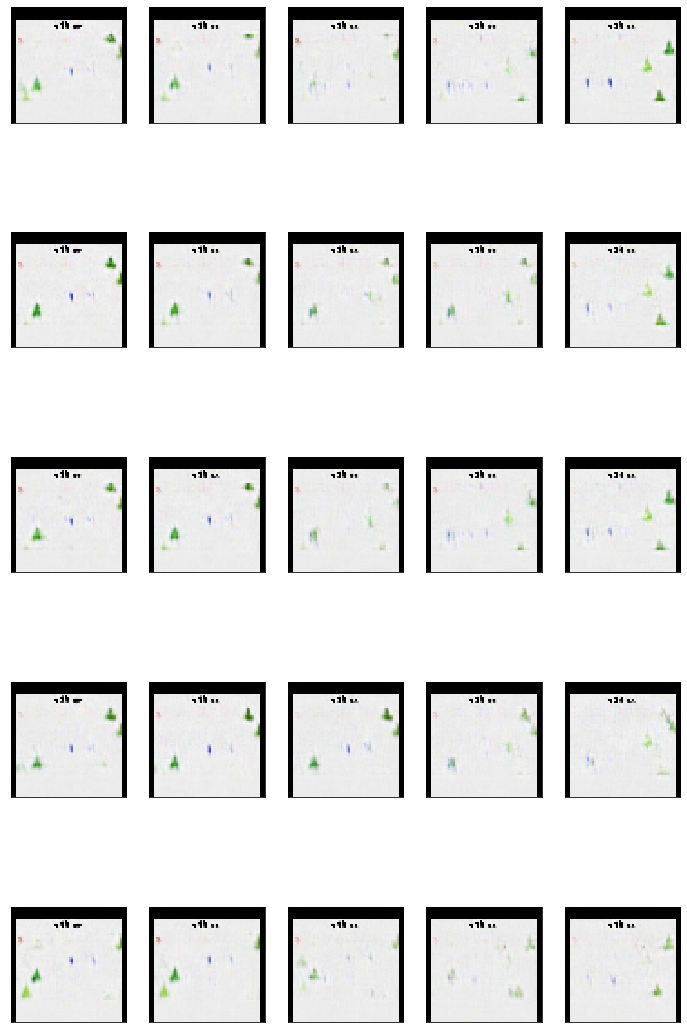

In [36]:
def predict_next_mu_logvar(current, action):
    input = np.zeros((1,65))
    input[0,:64] = current
    input[0,64] = action
    
    return model.predict(input)
    
_, ax = plt.subplots(n, 5, figsize=(12,20))
        
        
for x, ind in enumerate(random.sample(range(batch_size), n)):
    current = input_test[ind,:64]
    img = vae.decode_mu_logvar(obs_out[ind,:32].reshape(1,32), obs_out[ind,32:].reshape(1,32))
    ax[x,0].imshow(img[0,:,:,:])
    ax[x,0].get_xaxis().set_visible(False)
    ax[x,0].get_yaxis().set_visible(False)
    pred = current[0:64]
    
    for i in range(1,5):
        for j in range(5):
            pred = predict_next_mu_logvar(pred, 2)
        img = vae.decode_mu_logvar(pred[0,:32].reshape(1,32), pred[0,32:].reshape(1,32))
        ax[x,i].imshow(img[0,:,:,:])
        ax[x,i].get_xaxis().set_visible(False)
        ax[x,i].get_yaxis().set_visible(False)
    
plt.show()